In [149]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
import seaborn as sns
import numpy as np

from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV

from id3 import Id3Estimator
from id3 import export_graphviz
#import id3

from scipy.stats import skew
from scipy.stats.stats import pearsonr
from scipy import stats
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from scipy import stats

import keras




/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [87]:
test = pd.read_csv("test.csv")
test_shape = test.shape

train = pd.read_csv("train.csv")
train_shape = train.shape

train_shape, test_shape

((891, 12), (418, 11))

In [88]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


# A) EDA & Features Engineering :

In [89]:
"Features Engineering Function"

"Will keep editing this cell as I find features that need to be modified"

def process_missing(df):
    
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    
    return df

def Family_Size(df):
    df['Family_Size'] = df['SibSp'] + df['Parch'] + 1
    return df

def isAlone(df):
    df['Is_Alone'] = 0
    df.loc[df['Family_Size'] == 1, 'Is_Alone'] = 1
    return df

"""def process_Embarked(df):
    df['Embarked'] = df['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    return df"""
        
def process_Ticket(ticket):
        ticket = ticket.replace('.','')
        ticket = ticket.replace('/','')
        ticket = ticket.split()
        ticket = map(lambda t : t.strip() , ticket)
        ticket = filter(lambda t : not t.isdigit(), ticket)
        ticket = list(ticket)
        if (len(ticket)) > 0:
            return ticket[0]
        else: 
            return 'XXX'
    

In [90]:
train = process_missing(train)
test = process_missing(test)

train = process_age(train)
test = process_age(test)

train = process_fare(train)
test = process_fare(test)

train = process_titles(train)
test = process_titles(test)

train = process_cabin(train)
test = process_cabin(test)

"""train = process_Embarked(train)
test = process_Embarked(test)"""

train = Family_Size(train)
test = Family_Size(test)

train = isAlone(train)
test = isAlone(test)

"""train['Ticket'] = train['Ticket'].map(process_Ticket)
test['Ticket'] = test['Ticket'].map(process_Ticket)"""
# Dummies
"""train = create_dummies(train, 'Age_categories')
train = create_dummies(train, 'Fare_categories')
train = create_dummies(train, 'Title')
train = create_dummies(train, 'Cabin_type')
train = create_dummies(train, 'Sex')

holdout = create_dummies(holdout, 'Age_categories')
holdout = create_dummies(holdout, 'Fare_categories')
holdout = create_dummies(holdout, 'Title')
holdout = create_dummies(holdout, 'Cabin_type')
holdout = create_dummies(holdout, 'Sex')"""

for column in ["Age_categories","Fare_categories",'Title',"Sex", "Cabin_type", "Embarked"]:
    train = create_dummies(train,column)
    test = create_dummies(test,column)
    
    

In [91]:
test.info()
train.shape, test.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 46 columns):
PassengerId                   418 non-null int64
Pclass                        418 non-null int64
Name                          418 non-null object
Sex                           418 non-null object
Age                           418 non-null float64
SibSp                         418 non-null int64
Parch                         418 non-null int64
Ticket                        418 non-null object
Fare                          418 non-null float64
Embarked                      418 non-null object
Age_categories                418 non-null category
Fare_categories               418 non-null category
Title                         418 non-null object
Cabin_type                    418 non-null object
Family_Size                   418 non-null int64
Is_Alone                      418 non-null int64
Age_categories_Missing        418 non-null uint8
Age_categories_Infant         418 non-null uin

((891, 48), (418, 46))

In [92]:
train[['Family_Size', 'Survived']].groupby(['Family_Size'], as_index=False).mean().sort_values(by='Survived', ascending=False)


,Family_Size,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [93]:
# average age split by Sex, Pclass and Title
train[['Sex', 'Pclass', 'Title', 'Age']].groupby(['Sex', 'Pclass', 'Title']).mean()



Age
Sex    Pclass Title             
female 1      Miss     29.114583
              Mrs      32.790698
              Officer  49.000000
              Royalty  40.500000
       2      Miss     21.044118
              Mrs      33.547619
       3      Miss     10.745098
              Mrs      26.226190
male   1      Master    5.306667
              Mr       33.714953
              Officer  45.388889
              Royalty  42.333333
       2      Master    2.258889
              Mr       29.478022
              Officer  42.000000
       3      Master    4.515000
              Mr       20.479624

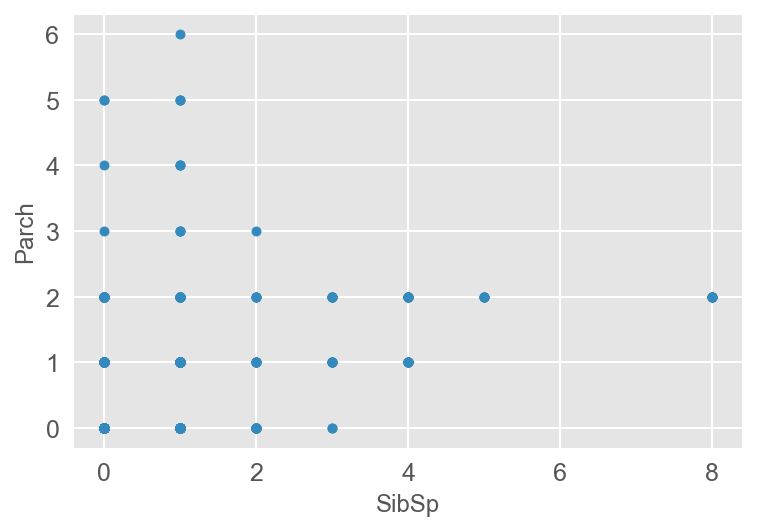

In [94]:
train.plot(x='SibSp', y = 'Parch', kind = "scatter" )

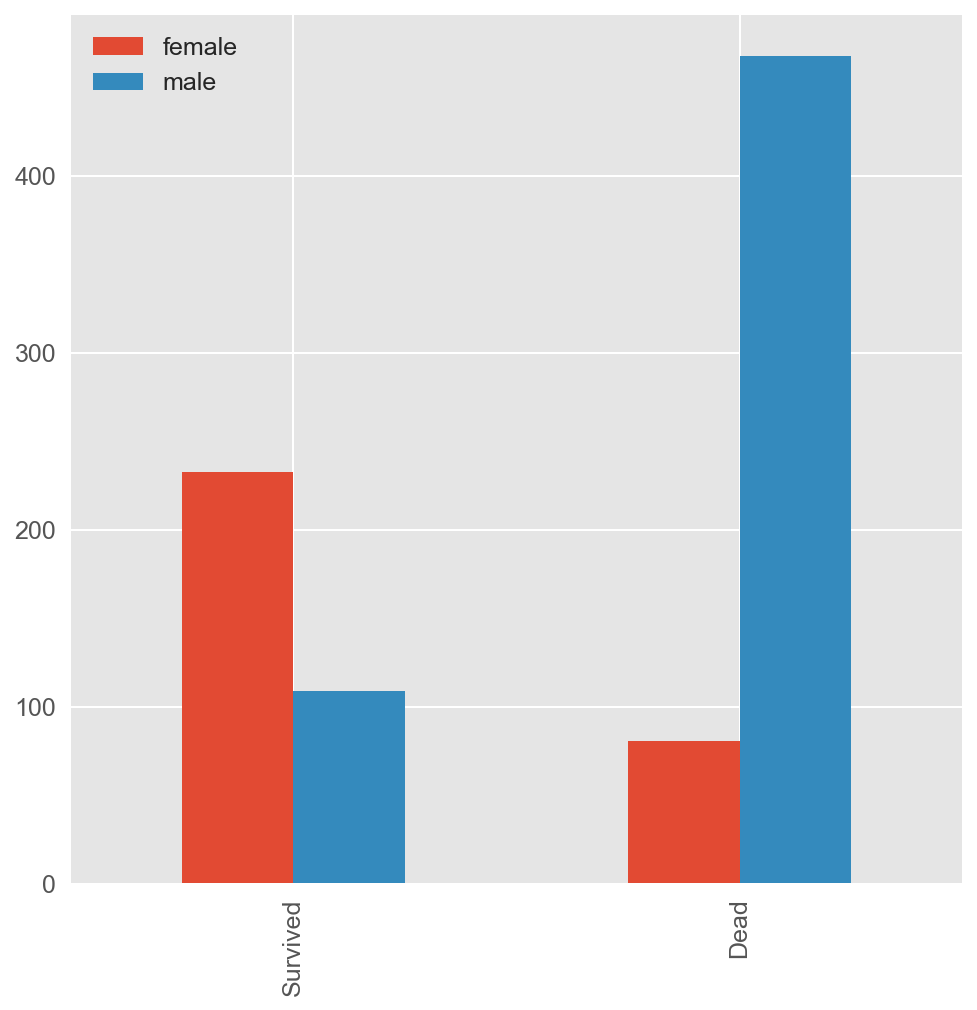

In [95]:
survived_sex = train[train['Survived']==1]['Sex'].value_counts()
dead_sex = train[train['Survived']==0]['Sex'].value_counts()
df = pd.DataFrame([survived_sex,dead_sex])
df.index = ['Survived','Dead']
df.plot(kind='bar', figsize=(8,8))

* We can immediately see that females survived in much higher proportions than males did.

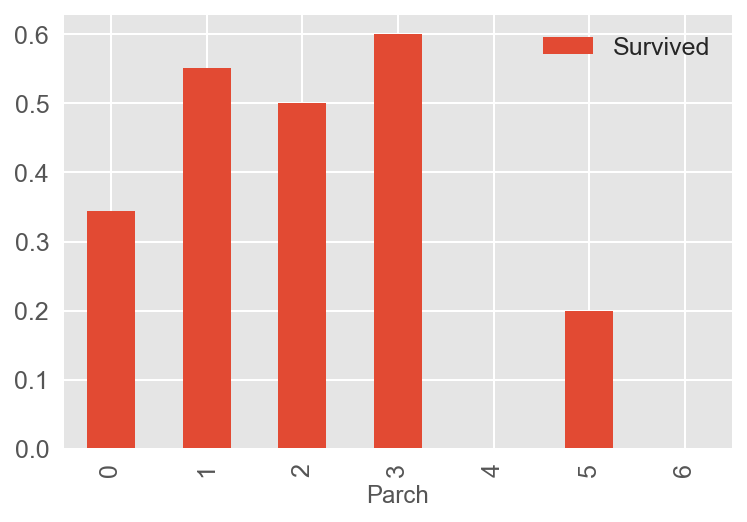

In [96]:
sex_pivot = train.pivot_table(index="Parch",values="Survived")
sex_pivot.plot.bar()
plt.show()

* We can see that a high proportion of those who survived had # of parents / children aboard the Titanic equal to 3 or less 

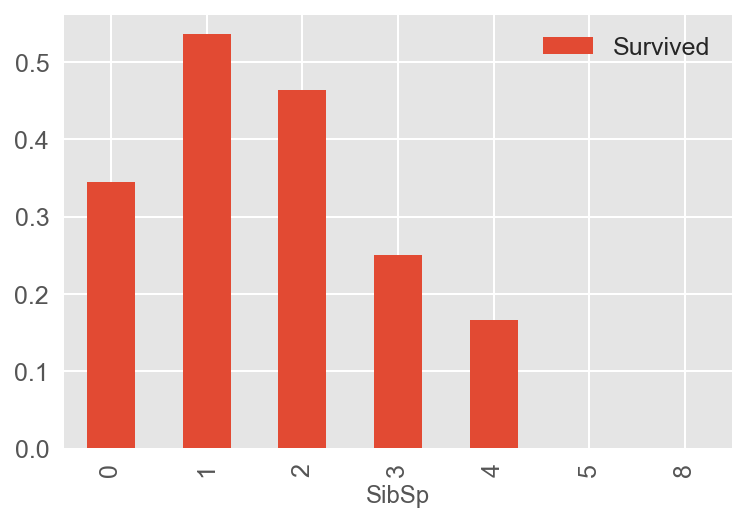

In [97]:
sex_pivot = train.pivot_table(index="SibSp",values="Survived")
sex_pivot.plot.bar()
plt.show()

* We can see that a high proportion of those who survived had # of siblings / spouses aboard the Titanic equal to 2 or less

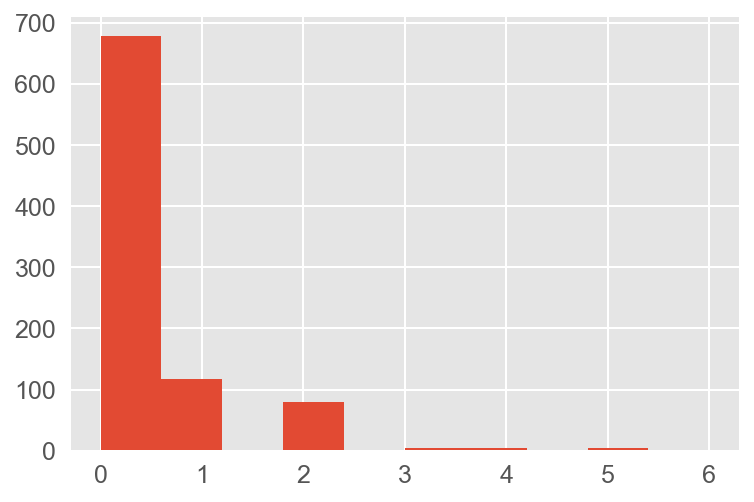

In [98]:
train["Parch"].hist()

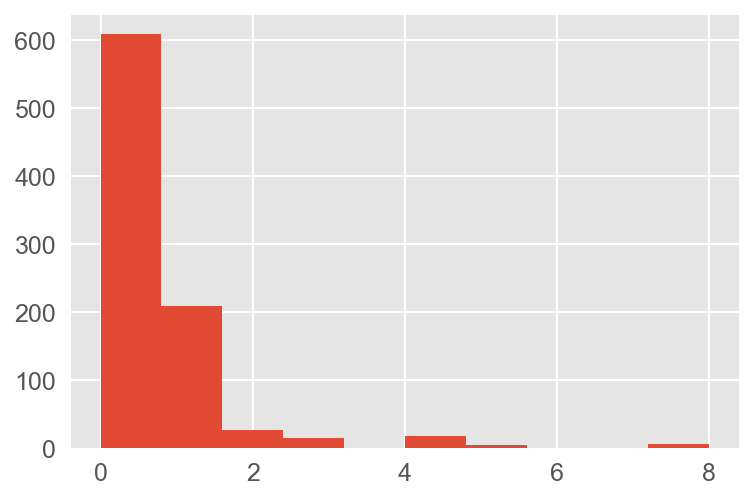

In [99]:
train["SibSp"].hist()

* As seen above most of the people on the titanic had "Parch" and "SibSp" equal to zero.

/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


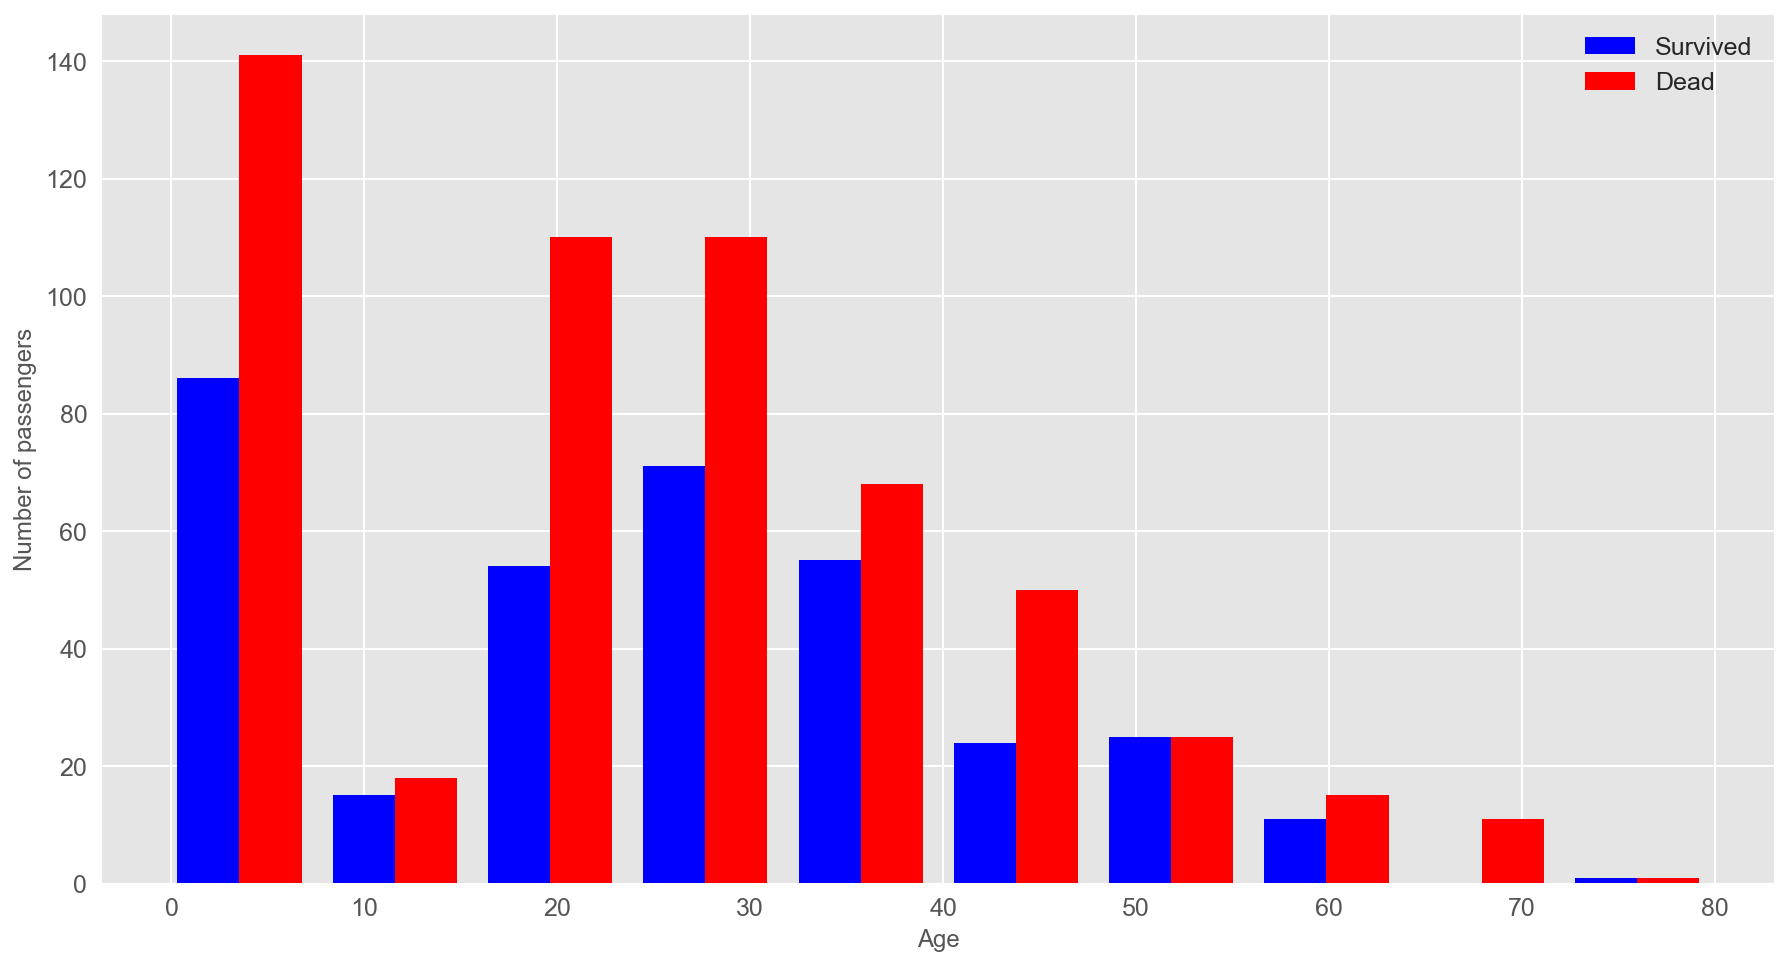

In [100]:
figure = plt.figure(figsize=(15,8))
plt.hist([train[train['Survived']==1]['Age'],train[train['Survived']==0]['Age']], color = ['b','r'],
         bins = 10,label = ['Survived','Dead'])
plt.xlabel('Age')
plt.ylabel('Number of passengers')
plt.legend()

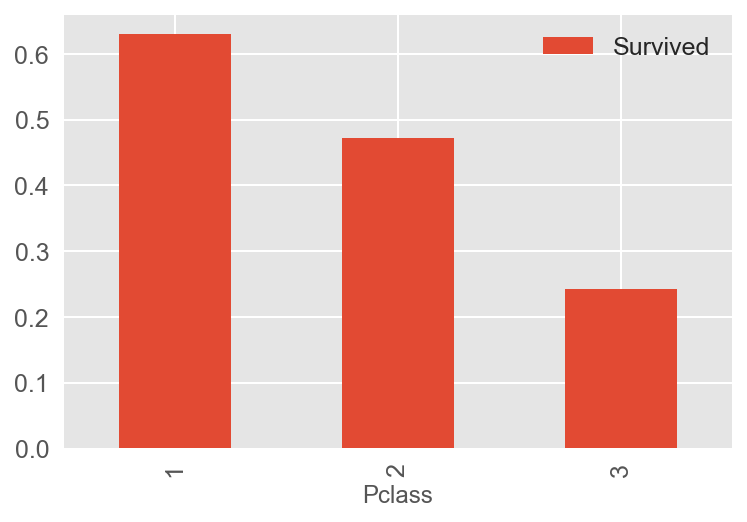

In [101]:
sex_pivot = train.pivot_table(index="Pclass",values="Survived")
sex_pivot.plot.bar()
plt.show()

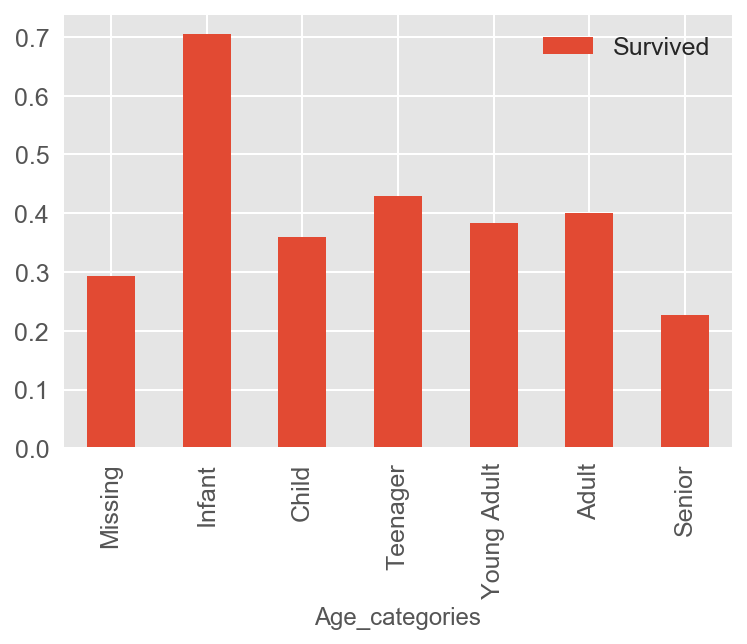

In [102]:
pivot = train.pivot_table(index="Age_categories",values='Survived')
pivot.plot.bar()
plt.show()

* Infants had a higher proportion of survival

In [103]:
corr_matrix = train.corr()
#corr.abs().nlargest(10, "SalePrice")["SalePrice"]

corr_matrix['Survived'].sort_values(ascending=False)

Survived                      1.000000
Sex_female                    0.543351
Title_Mrs                     0.344935
Title_Miss                    0.332795
Fare                          0.257307
Fare_categories_50-100        0.205384
Fare_categories_100+          0.182033
Cabin_type_B                  0.175095
Embarked_C                    0.168240
Cabin_type_D                  0.150716
Age_categories_Infant         0.150304
Cabin_type_E                  0.145321
Cabin_type_C                  0.114652
Title_Master                  0.085221
Parch                         0.081629
Fare_categories_12-50         0.065790
Cabin_type_F                  0.057935
Title_Royalty                 0.033391
Age_categories_Teenager       0.026859
Cabin_type_A                  0.022287
Age_categories_Adult          0.017590
Family_Size                   0.016639
Cabin_type_G                  0.016040
Age                           0.011497
Embarked_Q                    0.003650
Age_categories_Young Adul

In [104]:
"""plt.figure(figsize=(14,8))
plt.title('Overall Correlation of House Prices', fontsize=18)
sns.heatmap(corr_matrix,annot=False,cmap=sns.diverging_palette(10, 220, sep=80, n=7),linewidths=0.2, square=True)
plt.show()"""
;

''

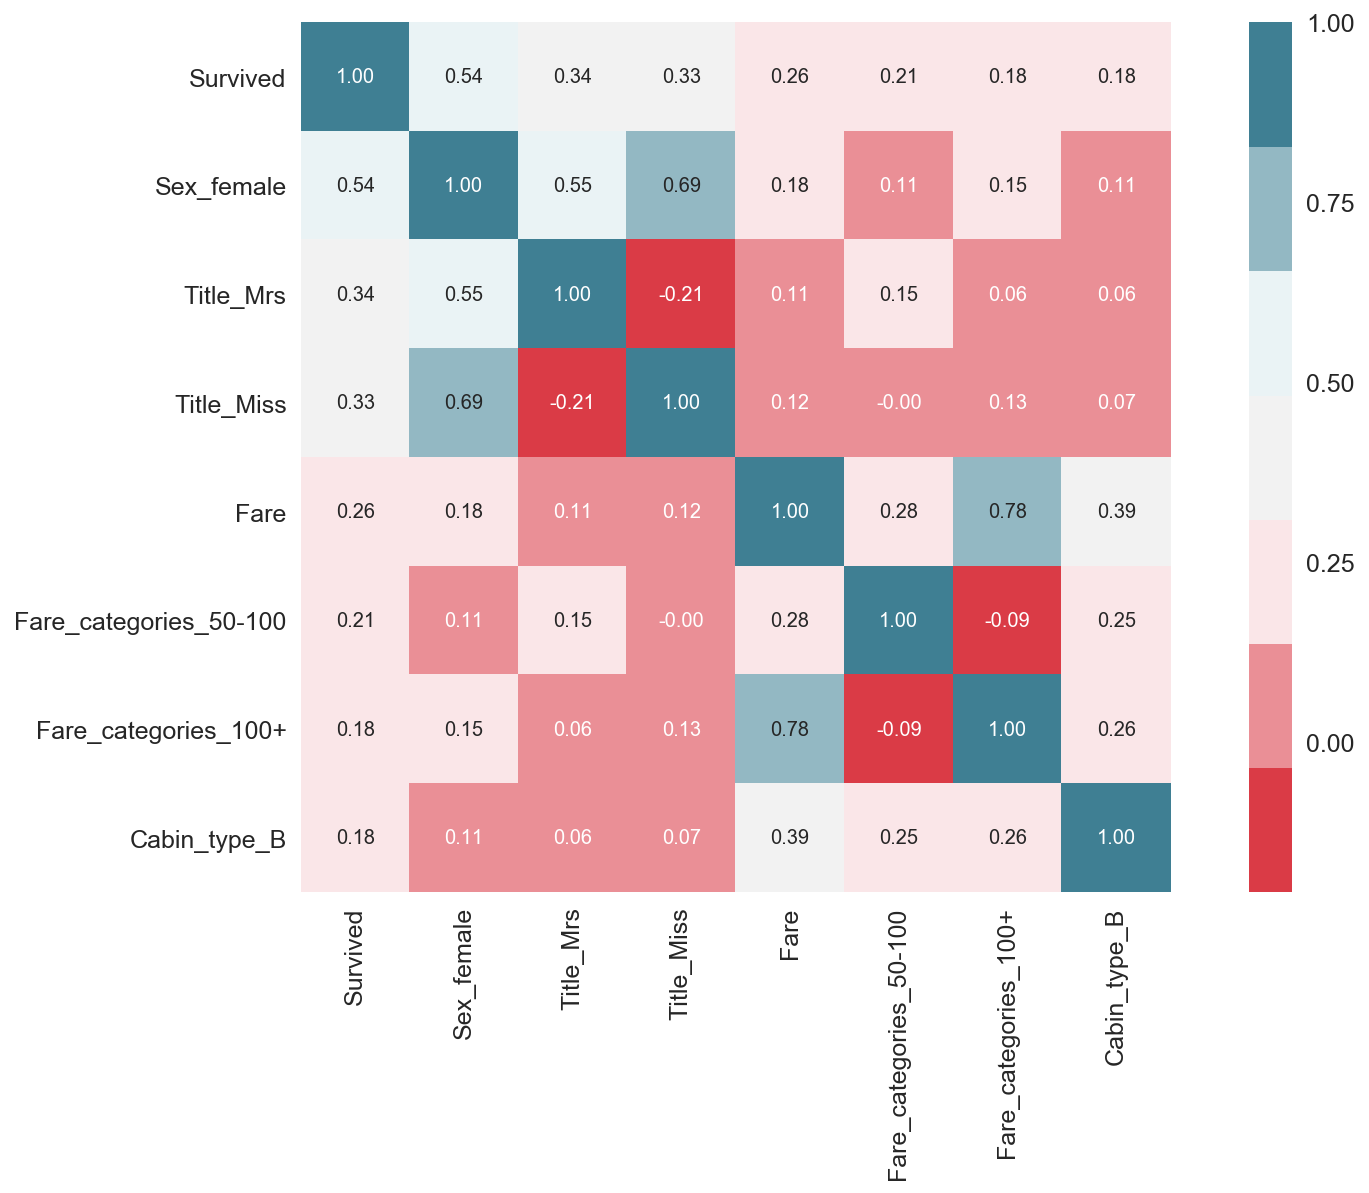

In [105]:
k = 8 #number of variables for heatmap
cols = corr_matrix.nlargest(k, 'Survived')['Survived'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
plt.figure(figsize=(14,8))
hm = sns.heatmap(cm, cbar=True, annot=True, cmap=sns.diverging_palette(10, 220, sep=80, n=7), square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [106]:
test_f.head()


,PassengerId,Pclass,Fare,Family_Size,Is_Alone,Age_categories_Missing,Age_categories_Infant,Age_categories_Child,Age_categories_Teenager,Age_categories_Young Adult,...,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_Unknown,Embarked_C,Embarked_Q,Embarked_S
0,892,0.060721,0.005787,0.020511,0.062869,0.0,0.0,0.0,0.0,0.076029,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0553,0.0,0.147442,0.000000
1,893,0.060721,0.005174,0.041022,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0553,0.0,0.000000,0.060858
2,894,0.040481,0.007160,0.020511,0.062869,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0553,0.0,0.147442,0.000000
3,895,0.060721,0.006402,0.020511,0.062869,0.0,0.0,0.0,0.0,0.076029,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0553,0.0,0.000000,0.060858
4,896,0.060721,0.009082,0.061533,0.000000,0.0,0.0,0.0,0.0,0.076029,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0553,0.0,0.000000,0.060858


In [107]:
train = train[train.select_dtypes(exclude = ["object", "category"]).columns]
test = test[test.select_dtypes(exclude = ["object", "category"]).columns]

#train = train.drop(['PassengerId'], axis=1)
train = train.drop(['Cabin_type_T'], axis=1)

#train = train.drop(['Fare'], axis=1)
train = train.drop(['Age'], axis=1)
train = train.drop(['Parch'], axis=1)
train = train.drop(['SibSp'], axis=1)

#holdout = holdout.drop(['Fare'], axis=1)
test = test.drop(['Age'], axis=1)
test = test.drop(['Parch'], axis=1)
test = test.drop(['SibSp'], axis=1)

In [120]:
def normalize(df):
    cols = df.columns
    temp = pd.DataFrame(preprocessing.normalize(df, axis=0, copy=True), columns=cols)
    temp['PassengerId'] = df['PassengerId']
    df = temp
    return df



In [121]:
train_f = normalize(train)
train_f = train_f.drop(['Survived'], axis=1)
targets = train['Survived']

test_f = normalize(test) 
test_f.shape, train_f.shape


((418, 35), (891, 35))

## Selecting Features using ExtraTreesClassifier

In [122]:
clf = ExtraTreesClassifier(n_estimators=200)
clf = clf.fit(train_f, targets)
features = pd.DataFrame()
features['feature'] = train_f.columns
features['importance'] = clf.feature_importances_
cols =  features.sort_values(['importance'],ascending=False)['feature']
model = SelectFromModel(clf, prefit=True)
train_new = model.transform(train_f)
test_new = model.transform(test_f)

In [123]:
test_new.shape, train_new.shape

((418, 8), (891, 8))

--------------------------
# Prediction Models :

In [125]:
X_train = train_new
Y_train = targets
#X_test  = test_new.drop("PassengerId", axis=1).copy()
X_test = test_new
X_train.shape, Y_train.shape, X_test.shape
;

''

### Logistic Regression

In [127]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

68.459999999999994

### Support Vector Machines

In [129]:
svc = SVC(kernel = 'rbf')
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

74.299999999999997

### KNN

In [130]:
knn = KNeighborsClassifier(n_neighbors = 2)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

78.0

### Gaussian Naive Bayes

In [131]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

79.120000000000005

### Descision Tree

* CART :

In [132]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

100.0

* ID3 :

In [133]:
DT_id3 = Id3Estimator()
DT_id3.fit(X_train, Y_train)

Y_pred = DT_id3.predict(X_test)
"""ID3_decision_tree = round(DT_id3.score(X_train, Y_train) * 100, 2)
ID3_decision_tree"""

"""accuracy_score(X_train, Y_pred) * 100"""
;

''

### Random Forest

In [134]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

100.0

--------------
## Models Evaluation :

In [135]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,100.00
5,Decision Tree,100.00
4,Naive Bayes,79.12
1,KNN,78.00
0,Support Vector Machines,74.30
2,Logistic Regression,68.46


In [145]:
# Random Forest
submission = pd.DataFrame({
        "PassengerId": test_f["PassengerId"],
        "Survived": Y_pred
    })

submission.to_csv('submission_final.csv', index=False)

------------------
## Ensemble Models with GridSearchCV:

In [162]:
forest = RandomForestClassifier(max_features='sqrt')

parameter_grid = {"criterion": ["entropy", "gini"],
                   "max_depth": [5, 10],
                   "max_features": ["log2", "sqrt"],
                   "min_samples_leaf": [1, 5],
                   "min_samples_split": [3, 5],
                   "n_estimators": [6, 9]
                  }

cross_validation = StratifiedKFold(targets, n_folds=5)

grid_search = GridSearchCV(forest,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(train_new, targets)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.8226711560044894
Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 9}


In [163]:
ext = ExtraTreesClassifier()

parameter_grid = {"criterion": ["entropy", "gini"],
                   "max_depth": [5, 10],
                   "max_features": ["log2", "sqrt"],
                   "min_samples_leaf": [1, 5],
                   "min_samples_split": [3, 5],
                   "n_estimators": [6, 9]
                  }

cross_validation = StratifiedKFold(targets, n_folds=5)

grid_search = GridSearchCV(ext,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(train_new, targets)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.8294051627384961
Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 9}


In [152]:
lr = LogisticRegression(penalty='l2')

parameter_grid = {
                 'tol' : [0.1,0.01,0.001,10,1],
                 'max_iter': [100, 200,210,240,250],
                 }

cross_validation = StratifiedKFold(targets, n_folds=5)

grid_search = GridSearchCV(lr,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(train_new, targets)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.6161616161616161
Best parameters: {'max_iter': 100, 'tol': 0.1}


In [165]:
dt = DecisionTreeClassifier()

parameter_grid = {
                 'max_depth' : [4,5,6,7,8,9],
                 "max_features": ["log2", "sqrt"],
                 "min_samples_leaf": [1, 5],
                 "min_samples_split": [3, 5],
                 'criterion': ['gini','entropy']
                 }

cross_validation = StratifiedKFold(targets, n_folds=5)

grid_search = GridSearchCV(dt,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(train_new, targets)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.8226711560044894
Best parameters: {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 3}


In [166]:
from sklearn.ensemble import AdaBoostClassifier
adaboost = AdaBoostClassifier(n_estimators=100)

cross_validation = StratifiedKFold(targets, n_folds=5)
adaboost.fit(train_new, targets)

print('Best score: {}'.format(cross_val_score(adaboost,train_new,targets,cv=10)))

Best score: [ 0.43333333  0.67777778  0.73033708  0.62921348  0.82022472  0.7752809
  0.78651685  0.85393258  0.80898876  0.61363636]


## Voting Classifier :

In [167]:
from sklearn.ensemble import VotingClassifier
eclf1 = VotingClassifier(estimators=[
        ('rf', forest),('etc',ext),('lr', lr), ('adb', adaboost), ('dt', dt)], voting='soft',
                        weights=[2,1,1,1,1])
eclf1 = eclf1.fit(train_new, targets)
predictions=eclf1.predict(test_new)
predictions

test_predictions=eclf1.predict(test_new)
test_predictions=test_predictions.astype(int)

In [168]:
test_predictions = eclf1.predict(test_new)
df_output = pd.DataFrame()
df_output['PassengerId'] = test['PassengerId']
df_output['Survived'] = test_predictions
df_output[['PassengerId','Survived']].to_csv('submission_final.csv',index=False)

### Conclusion : Using a Voting Classifier with some previously trained model resulted in the best predictions that I submitted.